# Text Classification with a Feedforward Network



The goal of this Project is to develop a Feedforward neural network for text classification. 



For that purpose, we will implement:

- Text processing methods for transforming raw text data into input vectors for your network


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix**
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function**
    - **Output layer** with a **softmax** activation.


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function 
    - Perform a **Forward pass** to compute intermediate outputs 
    - Perform a **Backward pass** to compute gradients and update all sets of weights 
    - Implement and use **Dropout** after each hidden layer for regularisation 



- Discuss the choice of hyperparameters 

- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, initialise it with the pre-trained weights. During training, should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights.



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? 


- Provide well documented and commented code describing all of your choices. 



- Provide efficient solutions by using Numpy arrays when possible. 



### Data 

The data we will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and we can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

We can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory





In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

#### First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_data = pd.read_csv('./data_topic/train.csv', header=None)
dev_data = pd.read_csv('./data_topic/dev.csv', header=None)
test_data = pd.read_csv('./data_topic/test.csv', header=None)

In [3]:
#sample of the data
train_data.head(5)
#dev_data.head(5)
#test_data.head(5)

,0,1
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [4]:
#info about the each dataset
train_data.info()
dev_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2400 non-null   int64 
 1   1       2400 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       150 non-null    int64 
 1   1       150 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       900 non-null    int64 
 1   1       900 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.2+ KB


In [5]:
#distribution of the class and check for missing entries
print(train_data[0].value_counts('1'))
print(dev_data[0].value_counts('1'))
print(test_data[0].value_counts('1'))

3    0.333333
1    0.333333
2    0.333333
Name: 0, dtype: float64
3    0.333333
2    0.333333
1    0.333333
Name: 0, dtype: float64
3    0.333333
2    0.333333
1    0.333333
Name: 0, dtype: float64


In [6]:
#check for any Null values
print("Train_data:", sum(np.isnan(train_data[0])))
print("Validation_data:", sum(np.isnan(dev_data[0])))
print("Test_data:", sum(np.isnan(test_data[0])))

Train_data: 0
Validation_data: 0
Test_data: 0


No missing values found in the datasets and all the three classes are equally distributed in train, dev and test sets indicating a balanced dataset.

# Create input representations


#### To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [7]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


In [8]:
train_data_txt = list(train_data[1])
dev_data_txt = list(dev_data[1])
test_data_txt = list(test_data[1])

### Unigram extraction from a document

#### You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

#### and returns:

- a list of all extracted features.


In [9]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    
    # this is to store the ngrams to be returned
    x = []
    

    
    if ngram_range[0]==1:
        x = x_uni


    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):

    # ignore unigrams
        if n==1: continue

        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)


    for n in ngrams:
        for t in n:
            x.append(t)

    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x

In [10]:
#sample Bag of words/ngrams
bow = extract_ngrams(train_data_txt[0], 
               ngram_range=(1,1), 
               stop_words=stop_words)
print(bow[:10])
print(bow[len(bow)-4:len(bow)-1])

['reuters', 'venezuelans', 'turned', 'out', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic']
['govern', 'next', 'two']


### Create a vocabulary of n-grams

#### Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

#### and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [11]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, 
                                 stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) 
                     if w[0] in vocab])
    
    
    return vocab, df, ngram_counts

#### Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [12]:
vocab_bow, df_bow, ngram_count_bow = get_vocab(train_data_txt, ngram_range=(1,1), min_df=3, keep_topN=2500, 
                                                      stop_words=stop_words)

The vocabulary for sentiment analysis is created by choosing the parameters of min_df, keep_topN to be 3 and 2500 respectively so as to restrict the size of vocabulary and to reduce the sparcity of the feature vector matrix.

In [13]:
#len(vocab_bow)
#vocab_bow

#### Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [14]:
id2word_bow = {i:list(vocab_bow)[i] for i in range(len(vocab_bow))}
word2id_bow = {list(vocab_bow)[i]:i for i in range(len(vocab_bow))}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

#### First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [15]:
#extraction of n-grams for each dataset
train_bow = [extract_ngrams(train_data_txt[x],ngram_range=(1,1),stop_words=stop_words, 
                              vocab=vocab_bow) for x in range(0, len(train_data_txt))]

dev_bow = [extract_ngrams(dev_data_txt[x],ngram_range=(1,1),stop_words=stop_words, 
                              vocab=vocab_bow) for x in range(0, len(dev_data_txt))]

test_bow = [extract_ngrams(test_data_txt[x],ngram_range=(1,1),stop_words=stop_words, 
                              vocab=vocab_bow) for x in range(0, len(test_data_txt))]

In [16]:
#sample extracted n-grams of the document
train_bow[5]

['reuters',
 'rwandan',
 'troops',
 'sunday',
 'sudan',
 'darfur',
 'first',
 'foreign',
 'force',
 'protect',
 'observers',
 'monitoring',
 'cease',
 'fire',
 'between',
 'sudanese',
 'government',
 'rebels',
 'troubled',
 'western',
 'region']

#### Then convert them into lists of indices in the vocabulary:

In [17]:
#conversion of bow to bow indices for each dataset
train_boi = [[word2id_bow.get(item,item)  for item in doc] for doc in train_bow]
dev_boi = [[word2id_bow.get(item,item)  for item in doc] for doc in dev_bow]
test_boi = [[word2id_bow.get(item,item)  for item in doc] for doc in test_bow]

In [18]:
#sample list of word indices of the document
train_boi[5]

[64,
 2333,
 1581,
 107,
 828,
 1013,
 540,
 860,
 2344,
 1932,
 1974,
 471,
 1632,
 1398,
 534,
 1655,
 1536,
 1552,
 1225,
 2076,
 1389]

#### Put the labels `Y` for train, dev and test sets into arrays: 

In [19]:
#create label variables
train_data_lbl = np.array(train_data[0])
dev_data_lbl = np.array(dev_data[0])
test_data_lbl = np.array(test_data[0])

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

#### First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

#### and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [20]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W = {}
    for i in range(0,len(hidden_dim)+1):
        if i == 0:
            W[i] = np.random.uniform(-init_val,init_val,(vocab_size,embedding_dim)).astype('float32')
        elif i == 1:
            W[i] = np.random.uniform(-init_val,init_val,(embedding_dim,hidden_dim[i-1])).astype('float32')
        else:
            W[i] = np.random.uniform(-init_val,init_val,(hidden_dim[i-2],hidden_dim[i-1])).astype('float32')
    
    #weights for the output layer
    if len(hidden_dim) == 0:
        W[len(hidden_dim)+1] = np.random.uniform(-init_val,init_val,(embedding_dim,num_classes)).astype('float32')
    else:
        W[len(hidden_dim)+1] = np.random.uniform(-init_val,init_val,(hidden_dim[-1],num_classes)).astype('float32')
    
    return W

In [21]:
#W = network_weights(vocab_size=len(vocab_bow),embedding_dim=300,hidden_dim=[], num_classes=3)
#print('W_0:', W[0].shape)
#print('W_out:', W[1].shape)

#### Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [22]:
def softmax(z):
    num = np.exp(z)
    sum_num = np.sum(num, axis=0)
    sig = num/sum_num
    return sig

#### Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [23]:
def categorical_loss(y, y_preds):
    y_preds = np.where(y_preds==0.0, 1e-5, y_preds)
    y_preds_up = np.where(y_preds==1.0, 0.99999, y_preds)
    l = -np.log(y_preds_up[y-1])
    return l

#### Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

#### and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [24]:
def relu(z):
    a = np.maximum(z,0)
    return a
    
def relu_derivative(z):
    dz = z.copy()
    dz[z <= 0] = 0;
    dz[z > 0] = 1;
    return dz

#### During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

#### and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [25]:
def dropout_mask(size, dropout_rate):
    
    dropout_vec = np.ones(size, dtype=float)
    idx = np.random.choice(range(size), round(size*dropout_rate), replace=False)
    #rounding to the integer value
    dropout_vec[idx] = 0
    
    return dropout_vec   

In [26]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[1. 1. 1. 0. 1. 0. 1. 1. 1. 1.]


#### Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

#### and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [27]:
def forward_pass(x, W, dropout_rate=0.2):
    
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    for layer in range(len(W)-1):
        if layer == 0:
            w_vec = [W[layer][indx] for indx in x]
            h_i = np.sum(w_vec,axis=0)/len(x)
        else:
            h_i = np.dot(ad_i, W[layer])
        h_vecs.append(h_i)
        a_i = relu(h_i)
        a_vecs.append(a_i)    
        #print(a_i)
        #print(a_vecs)
        d_i = dropout_mask(len(a_i), dropout_rate)
        dropout_vecs.append(d_i)
        ad_i = np.multiply(a_i, d_i) #activation output with dropout
        
    #predictions at the output layer
    pred = softmax(np.dot(ad_i,W[len(W)-1]))
    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['d'] = dropout_vecs
    out_vals['y_pred'] = pred 
    
    return out_vals
    

#### The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

#### and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [28]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    for layer in range(len(W)-1,0,-1):
        if layer == len(W)-1:
            y_cls = np.zeros(W[layer].shape[1])
            y_cls[y-1] = 1
            g_l = out_vals['y_pred'] - y_cls
            ad_l = np.multiply(out_vals['a'][-1],out_vals['d'][-1]).reshape(W[layer].shape[0],1)
            dw_l = np.dot(ad_l, g_l.reshape(1,W[layer].shape[1]))
            g_l = np.multiply(np.dot(W[layer],g_l).reshape(1,W[layer].shape[0]), out_vals['d'][layer-1])
            W[layer] = W[layer] - lr*dw_l
        else:  
            g_l = np.multiply(g_l, relu_derivative(out_vals['h'][layer]).reshape(1, W[layer+1].shape[0]))
            ad_l = np.multiply(out_vals['a'][layer-1], out_vals['d'][layer-1]).reshape(W[layer].shape[0],1)
            dw_l = np.dot(ad_l, g_l)
            g_l = np.multiply(np.dot(W[layer],g_l.T).reshape(1,W[layer].shape[0]), out_vals['d'][layer-1])
            W[layer] = W[layer] - lr*dw_l
        
    if not freeze_emb:
        x_en = np.zeros([W[0].shape[0],1])
        x_en[x] = 1
        g_l = g_l * relu_derivative(out_vals['h'][0]).reshape(1, W[0].shape[1])
        dw_l = np.dot(x_en,g_l)
        W[0] = W[0] - lr*dw_l
        
    return W


#### Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

#### The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


#### and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [29]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    training_loss_history = []
    validation_loss_history = []
    stop_train = False
    for epoch in range(epochs):  # loop over the dataset multiple times
        #randomise train set
        index = list(range(len(X_tr)))
        random.Random(epoch).shuffle(index)
        x_tr  = (np.array(X_tr)[index]).tolist()
        y_tr = Y_tr[index]
        
        running_loss = 0.0
        loss = 0.0
        le_tr = len(x_tr)
        for i in range(len(X_tr)):
            if len(x_tr[i]) != 0: #check for empty indices input
                out_vals = forward_pass(x_tr[i], W, dropout_rate=dropout)
                W = backward_pass(x_tr[i], y_tr[i], W, out_vals, lr=lr, freeze_emb=freeze_emb)
                running_loss = categorical_loss(y_tr[i], out_vals['y_pred'])
                loss += running_loss 
            else:
                le_tr = le_tr-1  #if empty reducing the size of the input
        #training
        avg_loss = loss/le_tr
        training_loss_history.append(avg_loss)
        
        # print progress
        if(print_progress):
            print('train_epoch: %d, loss: %.4f' % (epoch + 1, avg_loss))
            
        #validation
        if len(X_dev) !=0 and len(Y_dev) !=0: 
            running_loss_dev = 0.0
            loss_dev = 0.0
            le_dev = len(X_dev)
            for i in range(len(X_dev)):
                if len(X_dev[i]) != 0:
                    out_vals = forward_pass(X_dev[i], W, dropout_rate=dropout)
                    running_loss_dev = categorical_loss(Y_dev[i],out_vals['y_pred'])
                    loss_dev += running_loss_dev
                else:
                    le_dev = le_dev-1
            avg_loss_dev = loss_dev/le_dev
            validation_loss_history.append(avg_loss_dev)    
            # print progress
            if(print_progress):
                print('dev_epoch: %d, loss: %.4f' % (epoch + 1, avg_loss_dev))
        
            if (epoch > 3 and abs(validation_loss_history[epoch-1] - validation_loss_history[epoch]) < tolerance):
                break
    
    training_loss_history = np.array(training_loss_history)
    validation_loss_history = np.array(validation_loss_history)
    
    return W, training_loss_history, validation_loss_history

#### Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [30]:
W_int = network_weights(vocab_size=len(vocab_bow),embedding_dim=300,
                    hidden_dim=[], num_classes=3, init_val=0.1)

for i in range(len(W_int)):
    print('Shape W'+str(i), W_int[i].shape)

W, loss_tr, dev_loss = SGD(train_boi, train_data_lbl,
                            W_int,
                            X_dev=dev_boi, 
                            Y_dev=dev_data_lbl,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=100)


Shape W0 (2492, 300)
Shape W1 (300, 3)
train_epoch: 1, loss: 1.0978
dev_epoch: 1, loss: 1.0984
train_epoch: 2, loss: 1.0956
dev_epoch: 2, loss: 1.0952
train_epoch: 3, loss: 1.0930
dev_epoch: 3, loss: 1.0940
train_epoch: 4, loss: 1.0905
dev_epoch: 4, loss: 1.0926
train_epoch: 5, loss: 1.0878
dev_epoch: 5, loss: 1.0908


#### Plot the learning process:

In [31]:
#function to plot the training and validation loss history
def plot_loss(training_loss, validation_loss):
    epochs = np.linspace(1,len(training_loss),len(training_loss))
    plt.plot(epochs, training_loss, 'g', label='Training loss')
    plt.plot(epochs, validation_loss, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

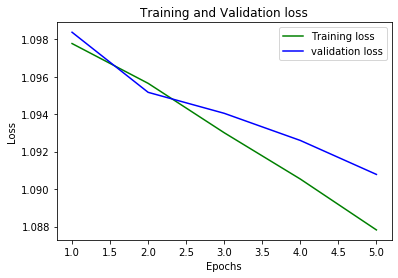

In [32]:
plot_loss(loss_tr, dev_loss)

#### Compute accuracy, precision, recall and F1-Score:

In [33]:
def get_evaluation_metrics(X, Y, W):
    preds_te = []
    y_input = Y
    for i in range(len(X)):
        if len(X[i]) != 0:  # check for empty input of indices
            preds_te.append(np.argmax(forward_pass(X[i], W, dropout_rate=0.0)['y_pred'])+1) #added '+1' to indicate the correct class label
        else:   
            y_input = np.delete(y_input, i)
    print('Accuracy:', accuracy_score(y_input,preds_te))
    print('Precision:', precision_score(y_input,preds_te,average='macro'))
    print('Recall:', recall_score(y_input,preds_te,average='macro'))
    print('F1-Score:', f1_score(y_input,preds_te,average='macro'))

In [34]:
#evaluation of metrics on the validation data
get_evaluation_metrics(dev_boi, dev_data_lbl, W)

Accuracy: 0.6333333333333333
Precision: 0.6742870500233754
Recall: 0.6333333333333334
F1-Score: 0.6198410334949941


In [35]:
#evaluation of metrics on the test data
get_evaluation_metrics(test_boi, test_data_lbl, W)

Accuracy: 0.6618464961067854
Precision: 0.6816487024737411
Recall: 0.6615198810850984
F1-Score: 0.6427287572304755


### Discuss how did you choose model hyperparameters ? 

In [36]:
random.seed(123)
np.random.seed(123)

In [37]:
lr=[0.001,0.01,0.1] 
epochs=[30,50,100] 
tolerance=[0.01]
dropout = [0.2, 0.5, 0.7]
embedding_dim = [100, 300, 500]
hidden_dim = []

In [38]:
# Implementation of hyperparameter tuning

def hypertune(X_tr, Y_tr, X_dev, Y_dev, iterate=10, print_metrics=True, use_pretrained=False):
    eval_ht = [] 
    param_ht = []
    hd_d = []
    for i in range(iterate):
        a,b,c,d = random.Random(i).choices(range(3), k=4)
        if len(embedding_dim) == 1:
            a = 0
        if len(epochs) == 1:
            d = 0
        if len(hidden_dim) != 0:
            hd_d = hidden_dim[random.Random(i).choice(range(len(hidden_dim)))]
        w = network_weights(vocab_size=len(vocab_bow),embedding_dim=embedding_dim[a], hidden_dim=hd_d, num_classes=3, init_val = 0.1)
        if use_pretrained:
            w[0] = w_glove
            w, tl, vl = SGD(X_tr, Y_tr, w, X_dev, Y_dev, lr[b], dropout[c], epochs=epochs[d], freeze_emb=True, tolerance=0.01, print_progress=False)
        else:
            w, tl, vl = SGD(X_tr, Y_tr, w, X_dev, Y_dev, lr[b], dropout[c], epochs=epochs[d], freeze_emb=False, tolerance=0.01, print_progress=False)
        #training_loss_ht.append(tl)
        #validation_loss_ht.append(vl)
        preds_te = [np.argmax(forward_pass(x, w, dropout_rate=0.0)['y_pred'])+1 
            for x,y in zip(X_dev,Y_dev)]
        eval_dict = {'Ac':accuracy_score(Y_dev,preds_te), 'Pr':precision_score(Y_dev,preds_te,average='macro'),
                  'Re':recall_score(Y_dev,preds_te,average='macro'), 'F1':f1_score(Y_dev,preds_te,average='macro')}
        eval_ht.append(eval_dict)
        param_ht.append({'lr':lr[b], 'epochs':epochs[d], 'dropout':dropout[c], 'embedding_dim': embedding_dim[a], 'hidden_dim': hd_d, 
                         'epochs_threshold_dev':len(vl)})

    indx = sorted(range(len(eval_ht)), key=lambda k: eval_ht[k]['Ac'], reverse=True)

    eval_ht_sorted = [eval_ht[i] for i in indx]
    param_ht_sorted = [param_ht[i] for i in indx]

    if print_metrics:
        print("Evaluation Metrics:", np.array(eval_ht_sorted[:5]))
        print("\nParameters:", np.array(param_ht_sorted[:5]))

In [40]:
##hypertuning with subset of randomly chosen values of all possible iterations (81)
#hypertune(train_boi, train_data_lbl, dev_boi, dev_data_lbl, 50, True)

Evaluation Metrics: [{'Ac': 0.9133333333333333, 'Pr': 0.9178000053776452, 'Re': 0.9133333333333334, 'F1': 0.9143278018278019}
 {'Ac': 0.9066666666666666, 'Pr': 0.912396480331263, 'Re': 0.9066666666666667, 'F1': 0.9079306250802207}
 {'Ac': 0.9066666666666666, 'Pr': 0.912396480331263, 'Re': 0.9066666666666667, 'F1': 0.9079306250802207}
 {'Ac': 0.9, 'Pr': 0.9074317738791423, 'Re': 0.9, 'F1': 0.9014987401748696}
 {'Ac': 0.9, 'Pr': 0.9074317738791423, 'Re': 0.9, 'F1': 0.9014987401748696}]

Parameters: [{'lr': 0.01, 'epochs': 30, 'dropout': 0.7, 'embedding_dim': 300, 'hidden_dim': [], 'epochs_threshold_dev': 22}
 {'lr': 0.01, 'epochs': 30, 'dropout': 0.5, 'embedding_dim': 100, 'hidden_dim': [], 'epochs_threshold_dev': 15}
 {'lr': 0.01, 'epochs': 100, 'dropout': 0.5, 'embedding_dim': 500, 'hidden_dim': [], 'epochs_threshold_dev': 19}
 {'lr': 0.01, 'epochs': 50, 'dropout': 0.5, 'embedding_dim': 100, 'hidden_dim': [], 'epochs_threshold_dev': 16}
 {'lr': 0.01, 'epochs': 100, 'dropout': 0.2, 'emb

Below is the table with top 5 best performed combinations of hypertuned parameters

|  | lr  | dropout  | embedding_dim | accuracy  | f1-score  | epoch  |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 1  | 0.01  | 0.7  | 300 | 0.9133  | 0.9143 |  30 |
| 2  | 0.01  | 0.5  | 100 | 0.9066  | 0.9079  | 30  |
| 3  | 0.01  | 0.5  | 500 | 0.9066  | 0.9079  | 100  |
| 4  | 0.01  | 0.5  | 100 | 0.9074  | 0.9014  | 50  |
| 5  | 0.01  | 0.2  | 300 | 0.9074  | 0.9014  | 100  |

Accuracy and the F-1 score of the validation is improved with hypertuning. The best performance for validation is achieved with higher dropout_rate (0.7) and learning rate(0.01), and the default value for embedding_dim(300) and epochs(30). 

In [41]:
W = network_weights(vocab_size=len(vocab_bow),embedding_dim=300,
                    hidden_dim=[], num_classes=3, init_val=0.1)
#model is trained again with the tuned parameters.
W, loss_tr, dev_loss = SGD(train_boi, train_data_lbl,
                            W,
                            X_dev=dev_boi, 
                            Y_dev=dev_data_lbl,
                            lr=0.01, 
                            dropout=0.7,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=30)

train_epoch: 1, loss: 1.0972
dev_epoch: 1, loss: 1.0959
train_epoch: 2, loss: 1.0936
dev_epoch: 2, loss: 1.0940
train_epoch: 3, loss: 1.0884
dev_epoch: 3, loss: 1.0899
train_epoch: 4, loss: 1.0795
dev_epoch: 4, loss: 1.0824
train_epoch: 5, loss: 1.0644
dev_epoch: 5, loss: 1.0720
train_epoch: 6, loss: 1.0394
dev_epoch: 6, loss: 1.0478
train_epoch: 7, loss: 1.0008
dev_epoch: 7, loss: 1.0162
train_epoch: 8, loss: 0.9448
dev_epoch: 8, loss: 0.9706
train_epoch: 9, loss: 0.8707
dev_epoch: 9, loss: 0.9173
train_epoch: 10, loss: 0.7935
dev_epoch: 10, loss: 0.8403
train_epoch: 11, loss: 0.7181
dev_epoch: 11, loss: 0.7873
train_epoch: 12, loss: 0.6580
dev_epoch: 12, loss: 0.7188
train_epoch: 13, loss: 0.5898
dev_epoch: 13, loss: 0.6398
train_epoch: 14, loss: 0.5316
dev_epoch: 14, loss: 0.5840
train_epoch: 15, loss: 0.4806
dev_epoch: 15, loss: 0.5443
train_epoch: 16, loss: 0.4423
dev_epoch: 16, loss: 0.5068
train_epoch: 17, loss: 0.4094
dev_epoch: 17, loss: 0.4616
train_epoch: 18, loss: 0.3821
de

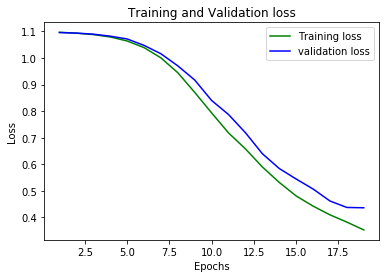

In [42]:
plot_loss(loss_tr, dev_loss)

The model looks a good fit as the validation loss and training loss are close and follow a similar pattern.

In [44]:
#evaluation of metrics on the test data with hypertuned model
get_evaluation_metrics(test_boi, test_data_lbl, W)

Accuracy: 0.8531701890989989
Precision: 0.8551698361224064
Recall: 0.8531475287997027
F1-Score: 0.8523707229104804


The hypertune method is executed for a combination of higher learning rates (lr), dropout rate and lower epochs along with the mix of embedding_dimension. Higher learning rates are chosen so that the learning process will be faster and reduces the number of training steps the network need to converge. As the learning rate values are increased the epoch size is reduced which should be sufficient for the model to converge given the tolerance and the default model(converged in 5 epochs). The dropout rate (regularisation) will help in penalizing the network to be sensitive to the specific weights of neurons which can lead to overfitting, and results in achieving a network with better generalization rather than having any affect on the performance. 

The accuracy is improved significantly with the hypertuned model. A higher dropout rate is obtained from the tuning putting regularisation/restriction on picking up any patterns or unwanted noise.

# Use Pre-trained Embeddings

#### Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [45]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300, vocab=set()):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [46]:
#choosing the embedding_dim default value
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id_bow, vocab=vocab_bow)

#### First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [47]:
W = network_weights(vocab_size=len(vocab_bow), embedding_dim=300, hidden_dim=[], num_classes=3, init_val = 0.1)
#replace the embedding weigths with w_glove 
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (2492, 300)
Shape W1 (300, 3)


In [48]:
W, loss_tr, dev_loss = SGD(train_boi, train_data_lbl,
                            W,
                            X_dev=dev_boi, 
                            Y_dev=dev_data_lbl,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.01,
                            epochs=100)

train_epoch: 1, loss: 1.0743
dev_epoch: 1, loss: 1.0469
train_epoch: 2, loss: 1.0008
dev_epoch: 2, loss: 0.9917
train_epoch: 3, loss: 0.9418
dev_epoch: 3, loss: 0.9256
train_epoch: 4, loss: 0.8892
dev_epoch: 4, loss: 0.8880
train_epoch: 5, loss: 0.8460
dev_epoch: 5, loss: 0.8493
train_epoch: 6, loss: 0.8060
dev_epoch: 6, loss: 0.8223
train_epoch: 7, loss: 0.7769
dev_epoch: 7, loss: 0.8040
train_epoch: 8, loss: 0.7528
dev_epoch: 8, loss: 0.7547
train_epoch: 9, loss: 0.7236
dev_epoch: 9, loss: 0.7111
train_epoch: 10, loss: 0.7070
dev_epoch: 10, loss: 0.7115


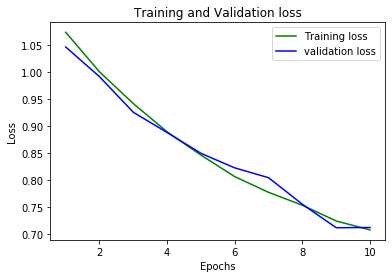

In [49]:
plot_loss(loss_tr, dev_loss)

In [50]:
#evaluation of metrics on the validation data
get_evaluation_metrics(dev_boi, dev_data_lbl, W)

Accuracy: 0.8666666666666667
Precision: 0.8745627186406796
Recall: 0.8666666666666667
F1-Score: 0.8680555555555557


In [51]:
#evaluation of metrics on the test data
get_evaluation_metrics(test_boi, test_data_lbl, W)

Accuracy: 0.8798665183537263
Precision: 0.8798635663121063
Recall: 0.8798327759197324
F1-Score: 0.8797433980414181


### Discuss how did you choose model hyperparameters ? 

In [52]:
lr=[0.001,0.01,0.1] 
epochs=[30]            #choosing the value from average_embedding hypertuned model
tolerance=[0.01]
dropout = [0.2, 0.5, 0.7]
embedding_dim = [300]  #choosing the value from average_embedding hypertuned model

In [54]:
##hypertuning the model with pretrained embeddings
#hypertune(train_boi, train_data_lbl, dev_boi, dev_data_lbl, 15, print_metrics=True, use_pretrained=True)

Evaluation Metrics: [{'Ac': 0.94, 'Pr': 0.9416863672182821, 'Re': 0.94, 'F1': 0.9400641359404246}
 {'Ac': 0.9333333333333333, 'Pr': 0.9375661375661376, 'Re': 0.9333333333333332, 'F1': 0.9336075083840724}
 {'Ac': 0.9333333333333333, 'Pr': 0.9358366271409749, 'Re': 0.9333333333333332, 'F1': 0.9333393458393459}
 {'Ac': 0.9333333333333333, 'Pr': 0.9334150326797386, 'Re': 0.9333333333333332, 'F1': 0.9331851552502188}
 {'Ac': 0.9266666666666666, 'Pr': 0.9284213291305489, 'Re': 0.9266666666666666, 'F1': 0.9267810272964913}]

Parameters: [{'lr': 0.1, 'epochs': 30, 'dropout': 0.7, 'embedding_dim': 300, 'hidden_dim': [], 'epochs_threshold_dev': 14}
 {'lr': 0.1, 'epochs': 30, 'dropout': 0.2, 'embedding_dim': 300, 'hidden_dim': [], 'epochs_threshold_dev': 5}
 {'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'embedding_dim': 300, 'hidden_dim': [], 'epochs_threshold_dev': 13}
 {'lr': 0.1, 'epochs': 30, 'dropout': 0.5, 'embedding_dim': 300, 'hidden_dim': [], 'epochs_threshold_dev': 5}
 {'lr': 0.1, 'epochs'

Below is the table with top 5 best performed combinations of hypertuned parameters

|  | lr  | dropout  | accuracy  | f1-score  | embedding  | epoch |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 1  | 0.1  | 0.7  | 0.94  | 0.9400  | 300 | 30 |
| 2  | 0.1  | 0.2  | 0.9333  | 0.9336  | 300 | 30  |
| 3  | 0.01  | 0.2  | 0.9333  | 0.9333  | 300 | 30  |
| 4  | 0.03  | 0.001  | 0.9333  | 0.9331  | 300 | 30  |
| 5  | 0.03  | 0.001  | 0.9266  | 0.9267  | 300 | 30  |

Accuracy of the validation is improved with hypertuning. The best performance for validation is achieved with higher learning rate, dropout than the default ones and the model is trained again with the tuned parameters.

In [55]:
W = network_weights(vocab_size=len(vocab_bow), embedding_dim=300, hidden_dim=[], num_classes=3, init_val = 0.1)
#replace the embedding weigths with w_glove 
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (2492, 300)
Shape W1 (300, 3)


In [56]:
#model is trained again with the tuned parameters.
W, loss_tr, dev_loss = SGD(train_boi, train_data_lbl,
                            W,
                            X_dev=dev_boi, 
                            Y_dev=dev_data_lbl,
                            lr=0.1, 
                            dropout=0.7,
                            freeze_emb=True,
                            tolerance=0.01,
                            epochs=30)

train_epoch: 1, loss: 0.8429
dev_epoch: 1, loss: 0.7283
train_epoch: 2, loss: 0.6360
dev_epoch: 2, loss: 0.5519
train_epoch: 3, loss: 0.5657
dev_epoch: 3, loss: 0.5463
train_epoch: 4, loss: 0.5197
dev_epoch: 4, loss: 0.5198
train_epoch: 5, loss: 0.5148
dev_epoch: 5, loss: 0.4619
train_epoch: 6, loss: 0.5129
dev_epoch: 6, loss: 0.4919
train_epoch: 7, loss: 0.4804
dev_epoch: 7, loss: 0.5234
train_epoch: 8, loss: 0.4901
dev_epoch: 8, loss: 0.4851
train_epoch: 9, loss: 0.4822
dev_epoch: 9, loss: 0.4226
train_epoch: 10, loss: 0.4799
dev_epoch: 10, loss: 0.5062
train_epoch: 11, loss: 0.4816
dev_epoch: 11, loss: 0.4306
train_epoch: 12, loss: 0.4647
dev_epoch: 12, loss: 0.4874
train_epoch: 13, loss: 0.4651
dev_epoch: 13, loss: 0.4310
train_epoch: 14, loss: 0.4676
dev_epoch: 14, loss: 0.3909
train_epoch: 15, loss: 0.4708
dev_epoch: 15, loss: 0.3692
train_epoch: 16, loss: 0.4591
dev_epoch: 16, loss: 0.4034
train_epoch: 17, loss: 0.4510
dev_epoch: 17, loss: 0.4374
train_epoch: 18, loss: 0.4564
de

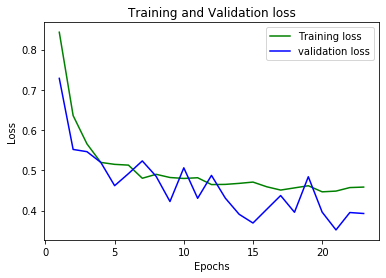

In [57]:
plot_loss(loss_tr, dev_loss)

The model might just be right with the validation loss picking up some oscillating noise and follow decreasing trend with the decrease in the training loss.

In [58]:
#evaluation of metrics on the test data with hypertuned model
get_evaluation_metrics(test_boi, test_data_lbl, W)

Accuracy: 0.8887652947719689
Precision: 0.8896361942175189
Recall: 0.8887365291713119
F1-Score: 0.8884159249258259


The hypertune method is executed for a combination of higher learning rates (lr) and higher dropout rates along with the default values selected. Higher learning rates are chosen so that the learning process will be faster and reduces the number of training steps the network need to converge. Higher values for dropout rate will put higher regularization affect on the network and gives more generalized results.

The accuracy is slightly improved with the hypertuned model. A higher learning rate and dropout rate is obtained from the tuning putting restriction on picking up any patterns or unwanted noise.

# Extend to support deeper architectures 

#### Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [59]:
W = network_weights(vocab_size=len(vocab_bow),embedding_dim=300,hidden_dim=[200,100], num_classes=3, init_val = 0.1)
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (2492, 300)
Shape W1 (300, 200)
Shape W2 (200, 100)
Shape W3 (100, 3)


In [60]:
W, loss_tr, dev_loss = SGD(train_boi, train_data_lbl,
                            W,
                            X_dev=dev_boi, 
                            Y_dev=dev_data_lbl,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.01,
                            epochs=50)

train_epoch: 1, loss: 1.0961
dev_epoch: 1, loss: 1.0976
train_epoch: 2, loss: 1.0917
dev_epoch: 2, loss: 1.0923
train_epoch: 3, loss: 1.0868
dev_epoch: 3, loss: 1.0869
train_epoch: 4, loss: 1.0789
dev_epoch: 4, loss: 1.0774
train_epoch: 5, loss: 1.0671
dev_epoch: 5, loss: 1.0643
train_epoch: 6, loss: 1.0507
dev_epoch: 6, loss: 1.0442
train_epoch: 7, loss: 1.0252
dev_epoch: 7, loss: 1.0166
train_epoch: 8, loss: 0.9776
dev_epoch: 8, loss: 0.9813
train_epoch: 9, loss: 0.9183
dev_epoch: 9, loss: 0.8856
train_epoch: 10, loss: 0.8343
dev_epoch: 10, loss: 0.8025
train_epoch: 11, loss: 0.7374
dev_epoch: 11, loss: 0.7174
train_epoch: 12, loss: 0.6533
dev_epoch: 12, loss: 0.6153
train_epoch: 13, loss: 0.5859
dev_epoch: 13, loss: 0.5800
train_epoch: 14, loss: 0.5333
dev_epoch: 14, loss: 0.4706
train_epoch: 15, loss: 0.4863
dev_epoch: 15, loss: 0.4706


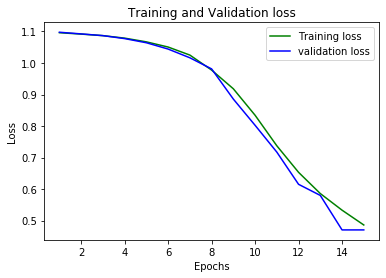

In [61]:
plot_loss(loss_tr, dev_loss)

In [62]:
#evaluation of metrics on the validation data
get_evaluation_metrics(dev_boi, dev_data_lbl, W)

Accuracy: 0.9
Precision: 0.9034391534391535
Recall: 0.9
F1-Score: 0.8999762604529238


In [63]:
#evaluation of metrics on the test data
get_evaluation_metrics(test_boi, test_data_lbl, W)

Accuracy: 0.8731924360400445
Precision: 0.8737795864559987
Recall: 0.8731475287997027
F1-Score: 0.8727695647962433


### Discuss how did you choose model hyperparameters ? 

In [66]:
lr=[0.001,0.01,0.1] 
epochs=[30]
tolerance=[0.01]
dropout = [0.2, 0.5, 0.7]
embedding_dim = [300]
hidden_dim = [[100,50], [200,100], [300,200]]  #restricting to 2 hidden layers

In [67]:
#hypertuning the model with pretrained embeddings and added hidden layers
hypertune(train_boi, train_data_lbl, dev_boi, dev_data_lbl, 25, print_metrics=True, use_pretrained=True)

Evaluation Metrics: [{'Ac': 0.9333333333333333, 'Pr': 0.9358366271409749, 'Re': 0.9333333333333332, 'F1': 0.9333393458393459}
 {'Ac': 0.9266666666666666, 'Pr': 0.9301587301587301, 'Re': 0.9266666666666666, 'F1': 0.9265899645244232}
 {'Ac': 0.92, 'Pr': 0.924388747747161, 'Re': 0.9199999999999999, 'F1': 0.9195372976129018}
 {'Ac': 0.92, 'Pr': 0.9246411483253588, 'Re': 0.9199999999999999, 'F1': 0.9198118923710492}
 {'Ac': 0.92, 'Pr': 0.9270248596631916, 'Re': 0.9199999999999999, 'F1': 0.9201694362984686}]

Parameters: [{'lr': 0.01, 'epochs': 30, 'dropout': 0.5, 'embedding_dim': 300, 'hidden_dim': [200, 100], 'epochs_threshold_dev': 10}
 {'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'embedding_dim': 300, 'hidden_dim': [200, 100], 'epochs_threshold_dev': 5}
 {'lr': 0.1, 'epochs': 30, 'dropout': 0.2, 'embedding_dim': 300, 'hidden_dim': [100, 50], 'epochs_threshold_dev': 15}
 {'lr': 0.01, 'epochs': 30, 'dropout': 0.5, 'embedding_dim': 300, 'hidden_dim': [200, 100], 'epochs_threshold_dev': 15}
 {

Below is the table with top 5 best performed combinations of hypertuned parameters

|  | lr  | dropout  | hidden_dim | accuracy  | f1-score  | embedding_dim | epoch  |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 1  | 0.01  | 0.5  | [200, 100] | 0.9333  | 0.9333  |  300 | 30 |
| 2  | 0.01  | 0.2  | [200, 100] | 0.9266  | 0.9265  | 300  | 30 |
| 3  | 0.1  | 0.2  | [100, 50] | 0.92  | 0.9195  | 300  | 30 |
| 4  | 0.01  | 0.5  | [200, 100] | 0.92  | 0.9198  | 300  | 30 |
| 5  | 0.1  | 0.5  | [100, 50] | 0.92  | 0.9201  | 300  | 30 |

Accuracy of the validation is improved with hypertuning. The best performance for validation is achieved with higher learning rate, dropout than the default ones and for the default hidden_dim(layers and neuron_size) and the model is trained again with the tuned parameters.

In [69]:
W = network_weights(vocab_size=len(vocab_bow),embedding_dim=300,
                    hidden_dim=[200, 100], num_classes=3, init_val=0.1)
W[0] = w_glove
#model is trained again with the tuned parameters.
W, loss_tr, dev_loss = SGD(train_boi, train_data_lbl,
                            W,
                            X_dev=dev_boi, 
                            Y_dev=dev_data_lbl,
                            lr=0.01, 
                            dropout=0.5,
                            freeze_emb=True,
                            tolerance=0.01,
                            epochs=30)

train_epoch: 1, loss: 1.0983
dev_epoch: 1, loss: 1.0994
train_epoch: 2, loss: 1.0972
dev_epoch: 2, loss: 1.0966
train_epoch: 3, loss: 1.0943
dev_epoch: 3, loss: 1.0928
train_epoch: 4, loss: 1.0882
dev_epoch: 4, loss: 1.0833
train_epoch: 5, loss: 1.0668
dev_epoch: 5, loss: 1.0431
train_epoch: 6, loss: 0.9835
dev_epoch: 6, loss: 0.9419
train_epoch: 7, loss: 0.8227
dev_epoch: 7, loss: 0.7340
train_epoch: 8, loss: 0.6794
dev_epoch: 8, loss: 0.6081
train_epoch: 9, loss: 0.5763
dev_epoch: 9, loss: 0.5318
train_epoch: 10, loss: 0.4873
dev_epoch: 10, loss: 0.4786
train_epoch: 11, loss: 0.4984
dev_epoch: 11, loss: 0.4324
train_epoch: 12, loss: 0.4475
dev_epoch: 12, loss: 0.3607
train_epoch: 13, loss: 0.4480
dev_epoch: 13, loss: 0.3560


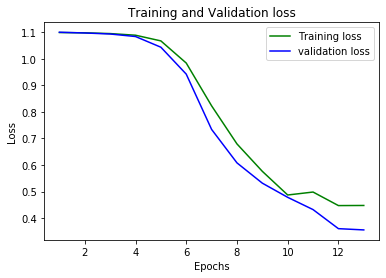

In [70]:
plot_loss(loss_tr, dev_loss)

The model is about right as the validation loss follows a sillilar trend with training loss. Towards the though the training loss is increased the valiodation kept decreasing which indicates a possibility of further learning.

In [71]:
#evaluation of metrics on the test data with hypertuned model
get_evaluation_metrics(test_boi, test_data_lbl, W)

Accuracy: 0.8909899888765295
Precision: 0.8909526323317394
Recall: 0.8908955778520995
F1-Score: 0.889925386417941


The hypertune method is executed for a combination of higher learning rates (lr), dropout rates and a combination hidden_dim of neuron sizes(keeping it to 2 hidden layers) along with the default values selected. Higher learning rates are chosen so that the learning process will be faster and reduces the number of training steps the network need to converge. Higher values for dropout rate will put higher regularization affect on the network and gives more generalized results. A mixed hidden_dim is provided as per the commonly follwed rule that 'the optimal size of the hidden layer is usually between the size of the input and size of the output layers' to see if the neuron size have any impact on the performance.

The accuracy is slightly improved with the hypertuned model. A higher learning rate and dropout rate is obtained from the tuning so as to avoid overfitting.

## Full Results

Add your final results here:                                                                                                  

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.8551  | 0.8531  | 0.8523  | 0.8531 |
| Average Embedding (Pre-trained)  | 0.8896  | 0.8887  | 0.8884  | 0.8887  |
| Average Embedding (Pre-trained) + X hidden layers    | 0.8909  | 0.8908  | 0.8899  | 0.8909  |

Please discuss why your best performing model is better than the rest.                                                         

So overall, the average embedding with pre-trained weights and deep neural network architecture with two hidden layers achieved the best performance results. We can clearly see that the pretrained weights with default parameters has a better performace (Accuracy - 0.87) when compared to the default average embedding model (Accuracy - 0.66). By adding hidden layers the performance is further increased as the hidden layers add more abstraction, the models might tend to learn better and yield better results but this depends on the data and other aspects of the problem. 

Please note that since the indices of the vocabulary keep changing everytime when the default get_vocab method is executed, the results might not reproduce as the embedding matrix changes. To achieve the reproducibility the get_vocab function can be modified to produce the same output for the vocab but in this case the default_method provided is used.

## References


1. COM6513 Natural Language Processing: Lecture - 6.

2. Lab - Python Introduction for NLP.

3. Assignment - 1.

4. Speech and Language Processing. Daniel Jurafsky & James H. Martin. December 30, 2020.
   "https://web.stanford.edu/~jurafsky/slp3/5.pdf" 

5. Javier Ideami, Feb 2019 - 
   "Coding a 2 layer neural network from scratch in Python" from https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2

6. Jason Brownlee, November 2016 - 
   "How to Code a Neural Network with Backpropagation In Python" from https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/
   
7. NiranjanKumar, April 2019 - 
   "Building a Feedforward Neural Network from Scratch in Python" from https://hackernoon.com/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b
   
8. A Simple Neural Network - With Numpy in Python from https://mlnotebook.github.io/post/nn-in-python/   